## Load voxel data

These are 2322 voxels with 200 time slices with a 2 sec TR.  
20 images belonging to 1 of 4 classes are shown in block trials.
The images are on for .3 seconds and off for .5 seconds. 20*.8 s = 16 second blocks.
Since TR=2, there are exactly 8 images per block.
This data has been polynomial detrended and motion corrected.

In [2]:
from scipy.io import loadmat
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from mne.decoding.receptive_field import _delay_time_series as delay_time_series
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
plt.ion()


In [4]:
data = loadmat(op.join('..', 'data', 'logisticdata.mat'))
voxels = data['voxeldata']
trials = data['trials']
n_t = len(trials)  # Number of time slices = 200
TR = 2  # TR in seconds
sfreq = 1. / TR

In [5]:
stim_coding = {'blank': 0, 'places': 1, 'faces': 2, 'objects': 3}

In [6]:
# Make indicies for the different stimulus types: blanks, places, faces, objects
ixs_blank = np.where(trials == stim_coding['blank'])
ixs_places = np.where(trials == stim_coding['places'])
ixs_faces = np.where(trials == stim_coding['faces'])
ixs_objects = np.where(trials == stim_coding['objects'])

# Exercise 1
Plot the trials to understand how the experiment was
performed.  You might want to try plotting using plot(trials) and
imagesc(trials').

In [7]:
# We are going to test for a binary stimulus classification of faces (1) and non-faces (0). 
# After you run finish the exercise you will try other classifications!
stimclas = np.zeros([1, n_t])
stimclas[0, ixs_faces] = 1

In [8]:
# We are now going to use sklearn to perform the logistic regresssion

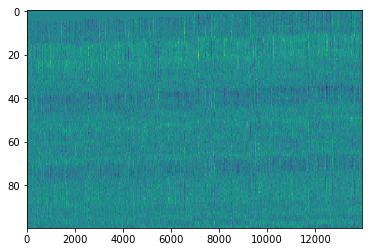

In [9]:
# First created a delayed version of our data
tmin = -10.
tmax = 0.
voxels_delayed = voxels.T
voxels_delayed = delay_time_series(voxels_delayed, tmin, tmax, sfreq)
n_delays = voxels_delayed.shape[0]
delays = np.linspace(tmin, tmax, n_delays)

# We'll define our input matrix, X, as the voxel data
X = np.hstack(voxels_delayed)

fig, ax = plt.subplots()
ax.imshow(X[:100], aspect='auto', interpolation=None)

In [10]:
# We'll define our output data, y, as the class of each presentation
y = trials.copy()

In [11]:

# Now define our training and test sets
n_datapoints = len(voxels_delayed)
cv = ShuffleSplit(n_splits=1, test_size=.25)

# the `split` method creates a python generator
# we'll turn it into a list and then take the indices of the first iteration
ixs_train, ixs_test = list(cv.split(X))[0]


In [12]:
# Initialize our model and fit it to the training data

max_iter = 1000
tolerance = .00001
est = LogisticRegression(solver='lbfgs', max_iter=max_iter, tol=tolerance)

X_train, y_train = X[ixs_train], y[ixs_train]
X_test, y_test = X[ixs_test], y[ixs_test]

# Fit the model
est.fit(X_train, y_train)

# Now we'll use this model to predict classes for the test set
y_pred = est.predict(X_test)
score = accuracy_score(y_test, y_pred)

/Users/choldgraf/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Exercise 2
On figure 2, show the prediction and the actual image classes.

In [13]:
# Coefficients are stored in this attribute
est.coef_

# Note that there is one set of coefficients for each class
# This corresponds to 4 "one vs. all" models that were fit
print(est.coef_.shape)
n_classes = est.coef_.shape[0]

(4, 13932)


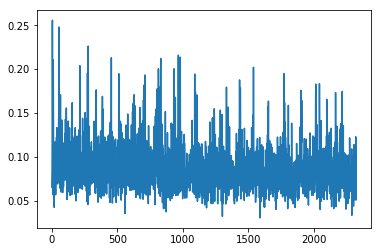

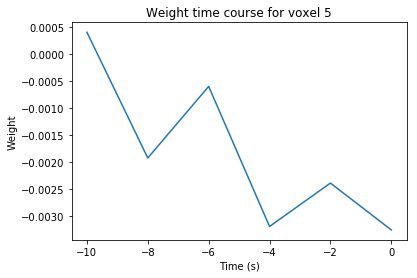

In [14]:
# We'll reshape the coefficients so that they're back to shape (delays, features)
coefficients = est.coef_.reshape([n_classes, n_delays, -1])

# Calculate the coefficients of highest absolute value across classes
# We'll average across the dimension corresponding to each class first
coefficients_abs = np.abs(coefficients).mean(0).sum(0)

fig, ax = plt.subplots()
ax.plot(coefficients_abs)

## Find the voxel with the highest weights to plot the time course
ix_max = np.argmax(coefficients_abs)

fig, ax = plt.subplots()
coefs_voxel = coefficients.mean(0)[:, ix_max]
ax.plot(delays, coefs_voxel)
ax.set(xlabel='Time (s)', ylabel='Weight', title='Weight time course for voxel {}'.format(ix_max))

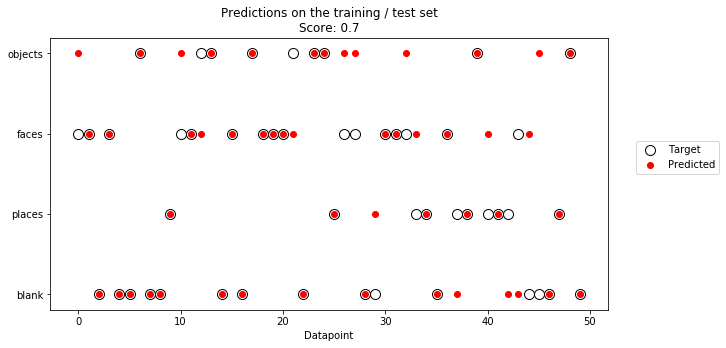

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ix_plt = range(len(ixs_test))
ax.scatter(ix_plt, y_test.ravel(), s=100, facecolor='w', edgecolor='k', label='Target')
ax.scatter(ix_plt, y_pred, c='r', label='Predicted')
ax.set(yticks=list(stim_coding.values()), xlabel='Datapoint', yticklabels=list(stim_coding.keys()),
       title='Predictions on the training / test set\nScore: {}'.format(score))
ax.legend(loc=(1.05, .5))

Clearly the model is working somewhat, but it is predicting faces where there aren't any.

# Exercise 3.

Repeat the previous using early stopping (see our gradient descent tutorials)
Remember that you will also have to specify a stopping index. After
fitting the model:

1. use strfFwd to obtain predictions
2. plot the results (figure 5)
3. plot the weight distribution as above. (figure 6)
4. plot the time course of the weights as above (figure 7)

In [16]:
# Initialize our model and fit it to the training data

max_iter = 1000
tolerance = 1
est = LogisticRegression(solver='lbfgs', max_iter=max_iter, tol=tolerance)

X_train, y_train = X[ixs_train], y[ixs_train]
X_test, y_test = X[ixs_test], y[ixs_test]

# Fit the model
est.fit(X_train, y_train)

# Now we'll use this model to predict classes for the test set
y_pred = est.predict(X_test)
score = accuracy_score(y_test, y_pred)

/Users/choldgraf/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


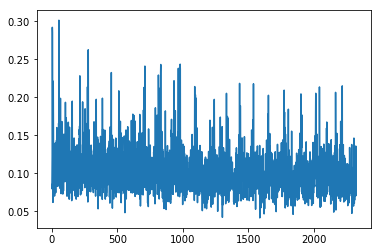

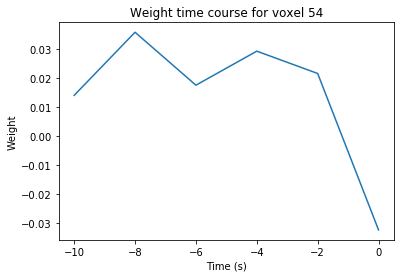

In [17]:
# We'll reshape the coefficients so that they're back to shape (delays, features)
coefficients = est.coef_.reshape([n_classes, n_delays, -1])

# Calculate the coefficients of highest absolute value across classes
# We'll average across the dimension corresponding to each class first
coefficients_abs = np.abs(coefficients).mean(0).sum(0)

fig, ax = plt.subplots()
ax.plot(coefficients_abs)

## Find the voxel with the highest weights to plot the time course
ix_max = np.argmax(coefficients_abs)

fig, ax = plt.subplots()
coefs_voxel = coefficients.mean(0)[:, ix_max]
ax.plot(delays, coefs_voxel)
ax.set(xlabel='Time (s)', ylabel='Weight', title='Weight time course for voxel {}'.format(ix_max))

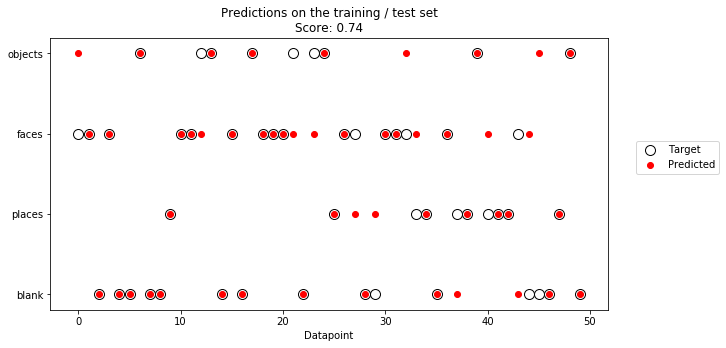

In [18]:
fig, ax = plt.subplots(figsize=(10, 5))
ix_plt = range(len(ixs_test))
ax.scatter(ix_plt, y_test.ravel(), s=100, facecolor='w', edgecolor='k', label='Target')
ax.scatter(ix_plt, y_pred, c='r', label='Predicted')
ax.set(yticks=list(stim_coding.values()), xlabel='Datapoint', yticklabels=list(stim_coding.keys()),
       title='Predictions on the training / test set\nScore: {}'.format(score))
ax.legend(loc=(1.05, .5))

# Exercise 4.
Repeat the fit using coordinate descent.  Plot the fit on 
figure 8 and the weight distribution on figure 9 and the time course of figure 10.  

In [19]:
# Initialize our model and fit it to the training data

max_iter = 1000
tolerance = 1
est = LogisticRegression(solver='newton-cg', max_iter=max_iter, tol=tolerance)

X_train, y_train = X[ixs_train], y[ixs_train]
X_test, y_test = X[ixs_test], y[ixs_test]

# Fit the model
est.fit(X_train, y_train)

# Now we'll use this model to predict classes for the test set
y_pred = est.predict(X_test)
score = accuracy_score(y_test, y_pred)

/Users/choldgraf/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


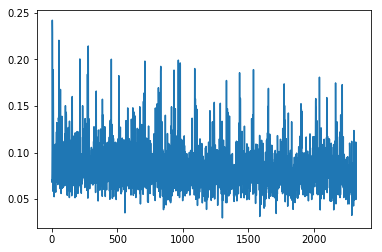

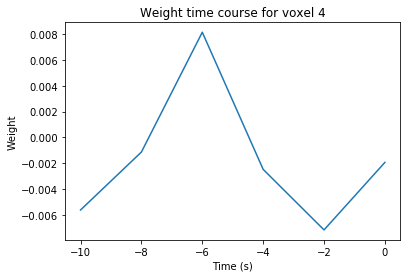

In [20]:
# We'll reshape the coefficients so that they're back to shape (delays, features)
coefficients = est.coef_.reshape([n_classes, n_delays, -1])

# Calculate the coefficients of highest absolute value across classes
# We'll average across the dimension corresponding to each class first
coefficients_abs = np.abs(coefficients).mean(0).sum(0)

fig, ax = plt.subplots()
ax.plot(coefficients_abs)

## Find the voxel with the highest weights to plot the time course
ix_max = np.argmax(coefficients_abs)

fig, ax = plt.subplots()
coefs_voxel = coefficients.mean(0)[:, ix_max]
ax.plot(delays, coefs_voxel)
ax.set(xlabel='Time (s)', ylabel='Weight', title='Weight time course for voxel {}'.format(ix_max))

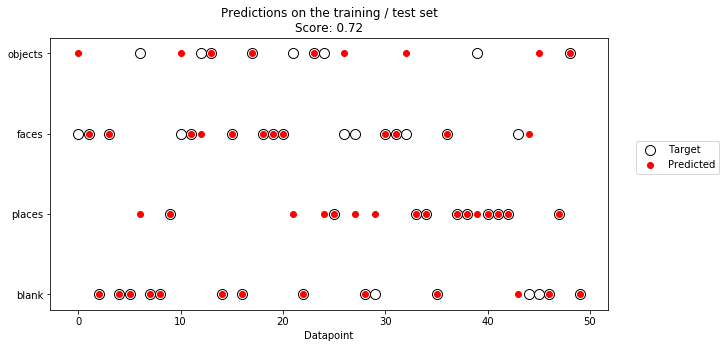

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))
ix_plt = range(len(ixs_test))
ax.scatter(ix_plt, y_test.ravel(), s=100, facecolor='w', edgecolor='k', label='Target')
ax.scatter(ix_plt, y_pred, c='r', label='Predicted')
ax.set(yticks=list(stim_coding.values()), xlabel='Datapoint', yticklabels=list(stim_coding.keys()),
       title='Predictions on the training / test set\nScore: {}'.format(score))
ax.legend(loc=(1.05, .5))